# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

## Due: 2021-10-7

## Name: Brian KYANJO

###  Assignment Tasks
### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [2]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

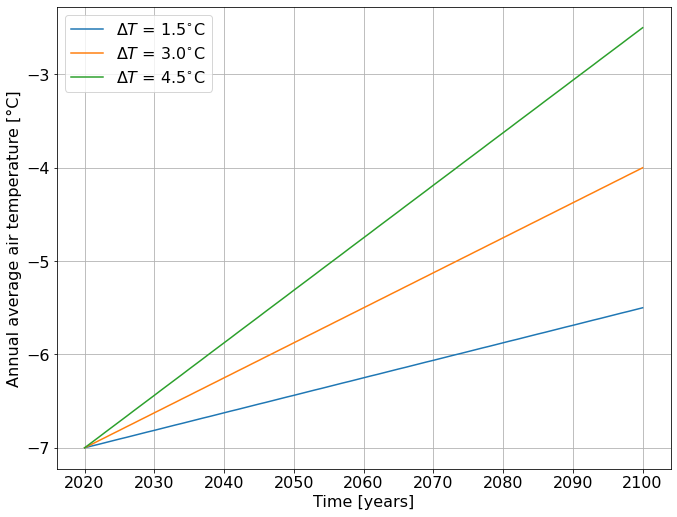

In [3]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [4]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [5]:
# Boundary conditions
Ttopamp = 35.0 #anual amplitude of temperature
Tbottom = -7.0

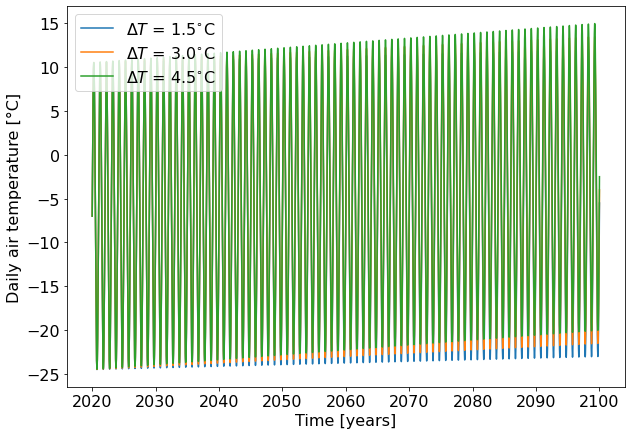

In [6]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [7]:
z = np.arange(dz/2, zs, dz)
Nz = z.size
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


### 5. Setup Initial Condition

In [8]:
Ts0 = Tbottom*np.ones((Nz,1))

### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

In [9]:
# Calculate diffusivity of permafrost soil
Ds = ks / (rhos * Cs)
print('Soil diffusivity = '+str(Ds)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
Ds = Ds*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(Ds)+' cm^2/day')

alpha = Ds*dt/(2.0*dz**2) #Note division by 2.0
print('Diffusion number '+str(alpha))

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Diffusion number 0.20540910647038682


In [10]:
#Matrix A
A = np.diag((1 + 2.0*alpha)*np.ones((Nz))) + \
    np.diag(-alpha*np.ones((Nz-1)),1) + \
    np.diag(-alpha*np.ones((Nz-1)),-1)
    
A[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

In [11]:
#Matrix B
B = np.diag((1 - 2.0*alpha)*np.ones((Nz))) + \
    np.diag(alpha*np.ones((Nz-1)),1) + \
    np.diag(alpha*np.ones((Nz-1)),-1)
    
B[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
B[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))
    

### 8. Apply Solution And Compute Temperatures

In [12]:
AiB = np.matmul(np.linalg.pinv(A),B) #A^-1 x B

def Tsoln(Ttop,AiB,Ts0,Tbottom,Nz,Nt):
    '''
    description: Computes temperatures
    input: Ttop - Boundary conditions at different scenarios
           AiB  - Multiplication of matrices A inverse and B 
           Tso  - Intial Conditions
    output: Ts  - array of computed solutions
    ''' 
    Ts = np.zeros((Nz,Nt)) #preallocate Memory
    for i in np.arange(Nt):
        if(i==0):
            Tsi = Ts0
        else:
            Tsi = Ts[:,i-1]
            Tsi[0] = Ttop[i]
            Tsi[-1] = Tbottom

        Tsip1 = np.matmul(AiB, Tsi)

        Ts[:,i] = np.squeeze(Tsip1)
    return Ts

### 9. Plot Results, Analyze, and Interpret

In [13]:
Ts15 = Tsoln(Ttop_15,AiB,Ts0,Tbottom,Nz,Nt)
Ts30 = Tsoln(Ttop_30,AiB,Ts0,Tbottom,Nz,Nt)
Ts45 = Tsoln(Ttop_45,AiB,Ts0,Tbottom,Nz,Nt)

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.

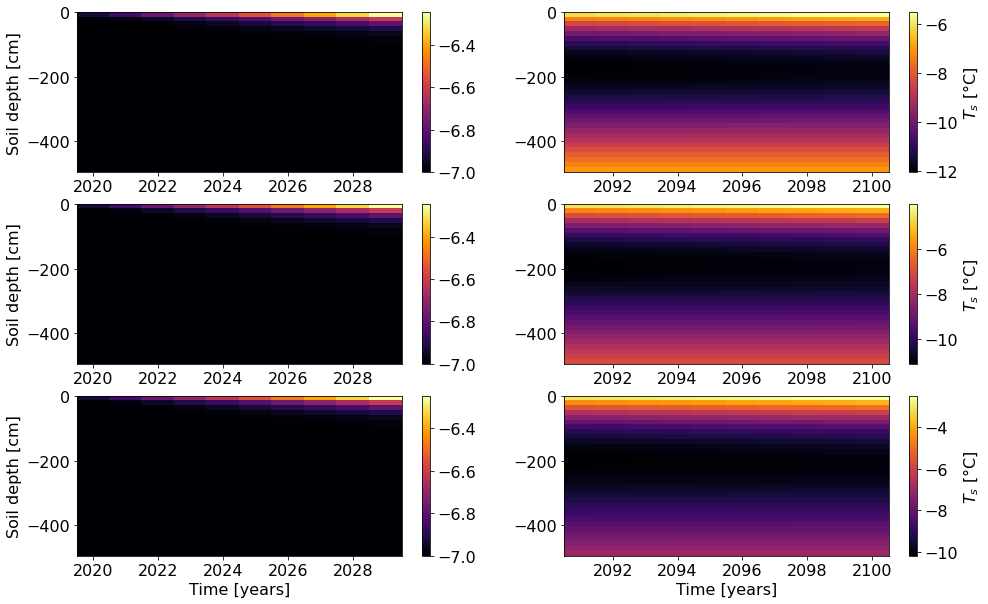

In [14]:
tt,zz = np.meshgrid(t_year[:10],z)
t_,zz = np.meshgrid(t_year[-10:],z)

T15 = np.ma.masked_where(Ts15>0.0,Ts15)
T30 = np.ma.masked_where(Ts30>0.0,Ts30)
T45 = np.ma.masked_where(Ts45>0.0,Ts45)

plt.figure(figsize=(16,10))
current_cmap = plt.cm.get_cmap('inferno')

plt.subplot(3,2,1)
plt.pcolormesh(tt,-zz,T15[:,:10],shading='auto',cmap=current_cmap)
plt.ylabel('Soil depth [cm]')
plt.colorbar()

plt.subplot(3,2,2)
plt.pcolormesh(t_,-zz,T15[:,-10:],shading='auto',cmap=current_cmap)
plt.colorbar(label='$T_s$ [°C]')

plt.subplot(3,2,3)
plt.pcolormesh(tt,-zz,T30[:,:10],shading='auto',cmap=current_cmap) 
plt.ylabel('Soil depth [cm]')
plt.colorbar()

plt.subplot(3,2,4)
plt.pcolormesh(t_,-zz,T30[:,-10:],shading='auto',cmap=current_cmap)
plt.colorbar(label='$T_s$ [°C]')

plt.subplot(3,2,5)
plt.pcolormesh(tt,-zz,T45[:,:10],shading='auto',cmap=current_cmap)
plt.ylabel('Soil depth [cm]')
plt.xlabel('Time [years]')
plt.colorbar()

plt.subplot(3,2,6)
plt.pcolormesh(t_,-zz,T45[:,-10:],shading='auto',cmap=current_cmap) 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.show()

2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 

In [15]:
iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()

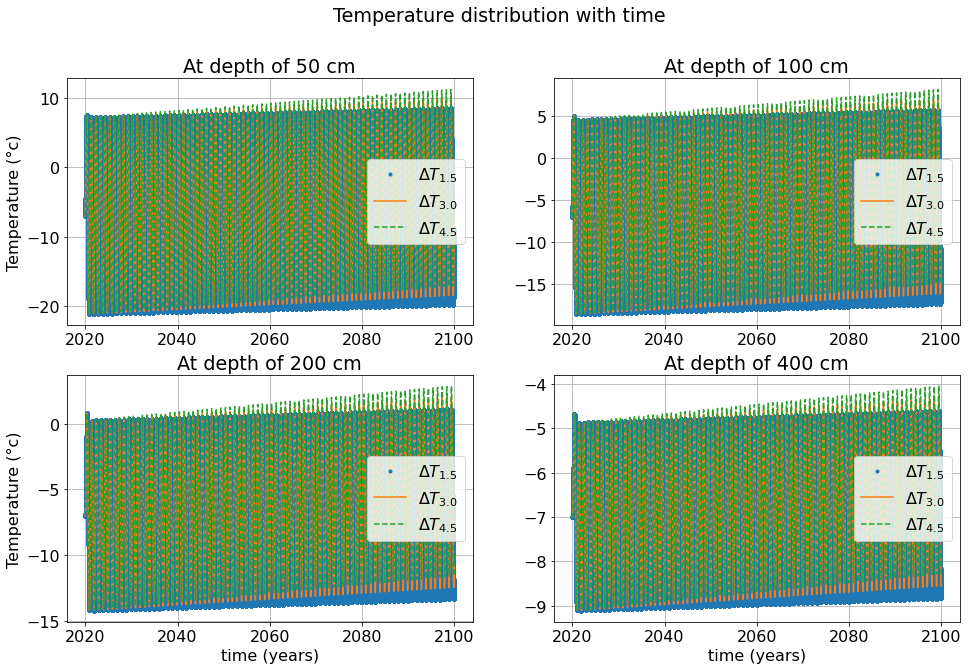

In [18]:
fig, axs = plt.subplots(2, 2,figsize=(16,10))
fig.suptitle('Temperature distribution with time')
axs[0,0].plot(t,Ts15[iz50,:],'.',label='$\Delta T_{1.5}$')
axs[0,0].plot(t,Ts30[iz50,:],label='$\Delta T_{3.0}$')
axs[0,0].plot(t,Ts45[iz50,:],'--',label='$\Delta T_{4.5}$')
axs[0,0].legend()
axs[0,0].grid()
axs[0,0].set_title('At depth of 50 cm')
axs[0,1].plot(t,Ts15[iz100,:],'.',label='$\Delta T_{1.5}$')
axs[0,1].plot(t,Ts30[iz100,:],label='$\Delta T_{3.0}$')
axs[0,1].plot(t,Ts45[iz100,:],'--',label='$\Delta T_{4.5}$')
axs[0,1].legend()
axs[0,1].grid()
axs[0,1].set_title('At depth of 100 cm')
axs[1,0].plot(t,Ts15[iz200,:],'.',label='$\Delta T_{1.5}$')
axs[1,0].plot(t,Ts30[iz200,:],label='$\Delta T_{3.0}$')
axs[1,0].plot(t,Ts45[iz200,:],'--',label='$\Delta T_{4.5}$')
axs[1,0].legend()
axs[1,0].grid()
axs[1,0].set_title('At depth of 200 cm')
axs[1,1].plot(t,Ts15[iz400,:],'.',label='$\Delta T_{1.5}$')
axs[1,1].plot(t,Ts30[iz400,:],label='$\Delta T_{3.0}$')
axs[1,1].plot(t,Ts45[iz400,:],'--',label='$\Delta T_{4.5}$')
axs[1,1].legend()
axs[1,1].grid()
axs[1,1].set_title('At depth of 400 cm')

#y and x-axis labelling
axs[0,0].set_ylabel('Temperature (°c)')
axs[1,0].set_ylabel('Temperature (°c)')
axs[1,1].set_xlabel('time (years)')
axs[1,0].set_xlabel('time (years)')

plt.show()

### 3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.

| Years  | Scenario 1.5 | Scenario 3.0 | Scenario4.0 |
|--------|:------------:|:------------:|-------------|
| First  |    200 cm    |    200 cm    |   198 cm    |
| Middle |    200 cm    |    218 cm    |   238 cm    |
| Final  |    200 cm    |    243 cm    |   268 cm    |